In [1]:
from pygtrie import Trie, StringTrie

In [2]:
st = StringTrie()
st

StringTrie([], separator='/')

In [3]:
st['dog'] = 1
st['dog/cat'] = 2
st['monkey'] = 3
st

StringTrie([('dog', 1), ('dog/cat', 2), ('monkey', 3)], separator='/')

In [7]:
st.longest_prefix('dog/cat')

('dog/cat': 2)

In [8]:
st.longest_prefix('dog')

('dog': 1)

## My version

In [135]:
from copy import deepcopy

from htools import ngrams, tolist
from lolviz import *

In [303]:
class TrieNode:
    
    def __init__(self, data=()):
        self.edges = {}
        self.stop_state = False
        for x in data:
            self.append(x)
        
    def append(self, seq):
        if not seq: 
            self.stop_state = True
            return
        x = seq[0]
        if x not in self.edges:
            self.edges[x] = TrieNode()
        self.edges[x].append(seq[1:])
        
    def __repr__(self):
        return f'{type(self).__name__}({list(self.edges.keys()) or ""})'

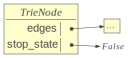

In [304]:
node = TrieNode()
objviz(node)

In [305]:
node

TrieNode()

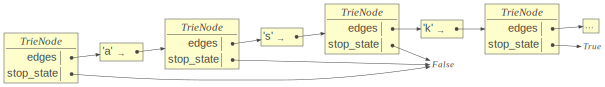

In [306]:
node.append('ask')
objviz(node)

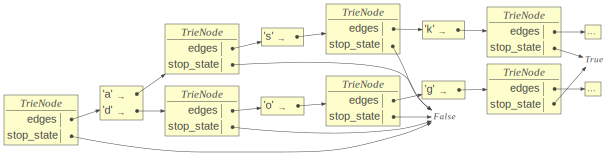

In [307]:
node.append('dog')
objviz(node)

In [308]:
node

TrieNode(['a', 'd'])

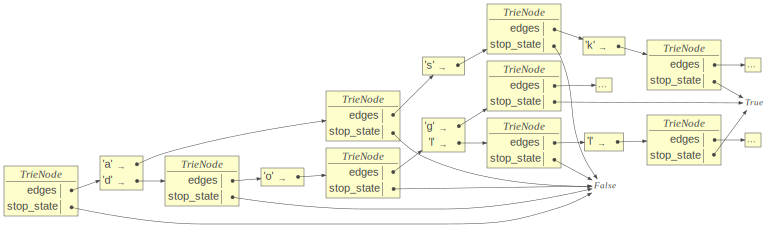

In [309]:
node.append('doll')
objviz(node)

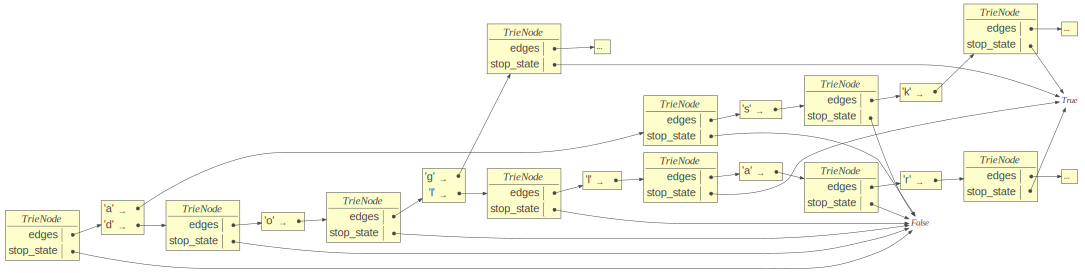

In [310]:
node.append('dollar')
objviz(node)

In [311]:
TrieNode(['dog', 'cat'])

TrieNode(['d', 'c'])

In [769]:
class Trie:
    
    def __init__(self, data=(), type_='infer'):
        """
        Parameters
        ----------
        data: str or list-like Iterable
            If provided, this should be one or more sequences to add to the
            try. Sequences could be strings, lists of strings (like word
            tokens), tuples of integers, etc. As of Dec 2020, this should NOT
            be numpy arrays or torch tensors.
        """
        self.head = TrieNode()
        self.type_ = type_ if isinstance(type_, type) else None
        for item in tolist(data):
            self.append(item)
        
    def append(self, seq):
        """Add a sequence to the trie. This operates in place."""
        self.head.append(seq)
        if not self.type_: self.type_ = type(seq)
            
    def __add__(self, seq):
        """Allows us to add items to a trie using + operator. This does not 
        alter the trie in place: to do that, use `append` or assign the result
        of this method back to your variable.
        
        Returns
        -------
        Trie
        """
        clone = deepcopy(self)
        clone.append(seq)
        return clone
    
    def __contains__(self, seq):
        """Check if a sequence is present in the trie.
        
        Returns
        -------
        bool
        """
        node = self.head
        for i, x in enumerate(seq):
            if x not in node.edges: return False
            node = node.edges[x]
        return node.stop_state
    
    def _values(self, seen, current, node=None):
        """Traverse all values starting from a given node and return them as a
        list. If a node is not explicitly provided, the head will be used and
        all values in the trie will be retrieved.
        """
        node = node or self.head
        if node.stop_state: seen.append(''.join(current))
        if not node.edges: return
        for key, node_ in node.edges.items():
            self._values(seen, current+[key], node_)
        return seen
    
    def values(self):
        """Wrapper for _values for when we want all values in the trie.
        Seems that we need to explicitly pass in lists for `seen` and
        `current` for some reason, otherwise we get an empty result.
        """
        return self._values([], [])
    
    def prefixed_by(self, seq, node=None):
        node = node or self.head
        for i, x in enumerate(seq):
            if x not in node.edges: return False
            node = node.edges[x]
        return self._values([], list(seq), node)
    
    # TODO: wishlist
    """
    -version of _values() that traverses the tree as a generator, perhaps as
        __iter__. This would
    let us easily apply logic at each step and avoids walking the whole 
    subtrie unless that's what we really want.
    -some sort of distance(seq1, seq2) method
    -generalize values() and prefixed_by() to work with strs, lists, etc.
        Maybe should make user either pass in data or specify type on init,
        then define a preprocessing function that we can always call in other
        methods?
            [UPDATE: storing type_ seems like a good start but annoyingly, it
            seems to break objviz.]
    -suffix=True option to init: I think we should be able to easily extend
    this to work as a suffix tree by simply reversing all inputs, perhaps as
    a preprocess func kind of like str.join for strings.
    -typos/neighbors (see Terence's slides)
    """

In [794]:
t = Trie(['dolphin', 'deer'])
# objviz(t)

In [797]:
objviz(t)

TypeError: 'type' object is not iterable

In [777]:
t.append('star')
t.append('study')
t.append('apple')
t.append('larkin')
t.append('app')
t.append('castle')
t.append('lake')
t.append('cake')

# objviz(t)

In [778]:
t.values()

['dolphin',
 'deer',
 'star',
 'study',
 'app',
 'apple',
 'larkin',
 'lake',
 'castle',
 'cake']

In [779]:
assert 'app' in t
assert 'apple' in t
assert 'ap' not in t
assert 'appleton' not in t
assert 'fox' not in t

In [780]:
tmp = t + 'candy'
objviz(tmp)

TypeError: 'type' object is not iterable

In [781]:
objviz(t)

TypeError: 'type' object is not iterable

In [782]:
t += 'car'
t += 'stunning'
t += 'stir'
t += 'sorry'
objviz(t)

TypeError: 'type' object is not iterable

In [783]:
t.prefixed_by('stu')

['study', 'stunning']

In [784]:
t.prefixed_by('ap')

['app', 'apple']

In [785]:
t.values()

['dolphin',
 'deer',
 'star',
 'study',
 'stunning',
 'stir',
 'sorry',
 'app',
 'apple',
 'larkin',
 'lake',
 'castle',
 'cake',
 'car']

In [786]:
def walk(node, seen, current):
    if node.stop_state: seen.append(''.join(current))
    if not node.edges: return
    for key, node_ in node.edges.items():
        walk(node_, seen, current+[key])
    return seen

In [789]:
res = walk(t.head, [], [])

sorted(res) ==  ['app',
 'apple',
 'cake',
 'car',
 'castle',
 'deer',
 'dolphin',
 'lake',
 'larkin',
 'sorry',
 'star',
 'stir',
 'study',
 'stunning']

True

In [792]:
def prefixed_by(node, seq):
    for i, x in enumerate(seq):
        print(i, x)
        if x not in node.edges: return False
        node = node.edges[x]
    return walk(node, [], list(seq))

In [793]:
_ = prefixed_by(t.head, 'app')
print(_)

0 a
1 p
2 p
['app', 'apple']


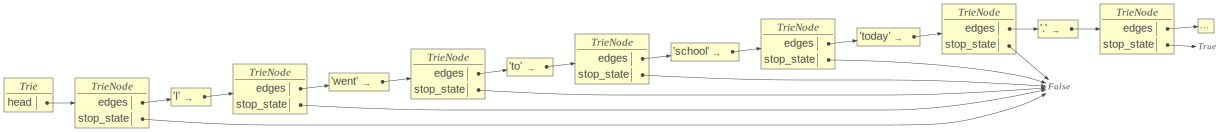

In [232]:
t2 = Trie()
t2.append(['I',  'went', 'to', 'school', 'today', '.'])
objviz(t2)

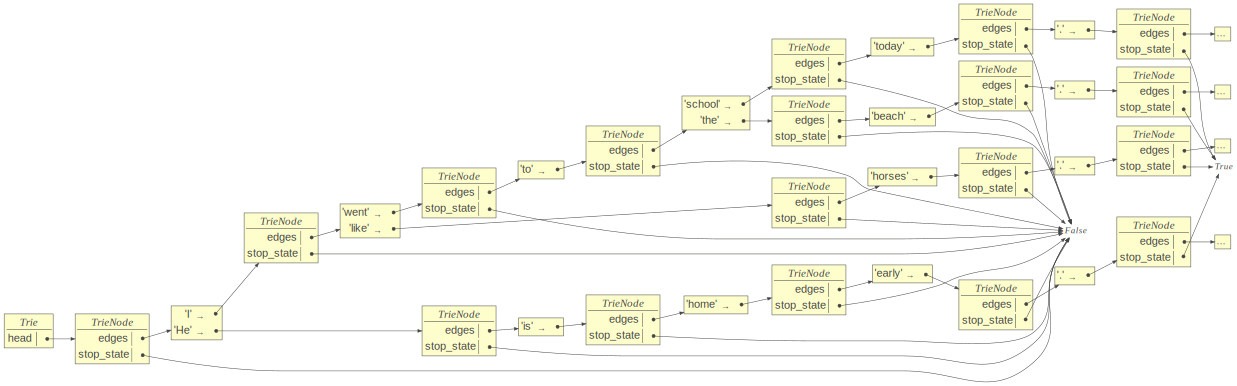

In [118]:
t2.append(['I',  'like', 'horses', '.'])
t2.append(['He', 'is', 'home', 'early', '.'])
t2.append(['I', 'went', 'to', 'the', 'beach', '.'])
objviz(t2)

In [133]:
ex = [
    'It is cold and windy.',
    'The food was still hot.',
    'It is not warm.',
    'The cow mooed loudly.',
    'It is cold and snowy.'
]

t3 = Trie()
for e in ex:
    t3.append(
        list(map(tuple, ngrams(e.split(), 2, 2, False)))
    )

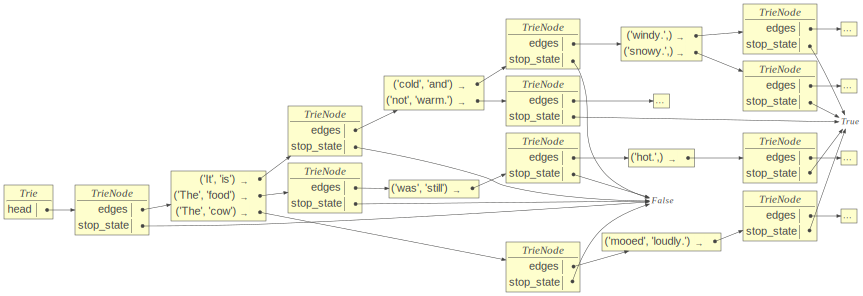

In [134]:
objviz(t3)

<class 'str'>


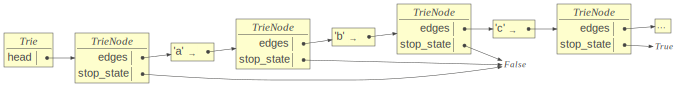

In [157]:
t4 = Trie('abc')
objviz(t4)

<class 'list'>


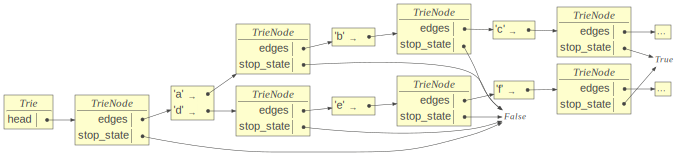

In [158]:
t5 = Trie(['abc', 'def'])
objviz(t5)